In [35]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
%cd /content/drive/MyDrive/WAVES

/content/drive/MyDrive/WAVES


In [21]:
import os
import numpy as np
from PIL import Image
from distortions.distortions import apply_distortion, apply_single_distortion
import torchvision.transforms.functional as TF

In [37]:
# 1. 사용자 입력 받기
distortion_type = input("공격 유형을 입력하세요 (compression, noise, rotation, etc.): ").strip()
strength = float(input("강도 값을 입력하세요 (예: 0.7은 상대적 강도, 30은 절대값): "))
relative = input("강도를 상대값으로 적용할까요? (yes/no): ").strip().lower() == "yes"

# 2. 폴더 경로
input_dir = "/content/drive/MyDrive/ssl_watermarking/ssl_output/imgs"
output_dir = "/content/drive/MyDrive/ssl_watermarking/ssl_waves"
os.makedirs(output_dir, exist_ok=True)

# 3. 공격 실행 루프
for idx in range(1, 51):
    input_path = os.path.join(input_dir, f"{idx:02d}.png")
    output_path = os.path.join(output_dir, f"attacked_{idx:02d}.png")

    # 이미지 로드 및 공격
    pil_img = Image.open(input_path).convert("RGB")
    attacked_img = apply_single_distortion(
        pil_img,
        distortion_type=distortion_type,
        strength=strength if not relative else None,
        distortion_seed=idx,
    ) if not relative else apply_distortion(
        [pil_img],
        distortion_type=distortion_type,
        strength=strength,
        distortion_seed=idx,
        same_operation=True,
        relative_strength=True,
        return_image=True,
    )[0]

    # 저장
    attacked_img.save(output_path)
    print(f"[{idx}/50] 저장 완료: {output_path}")


공격 유형을 입력하세요 (compression, noise, rotation, etc.): noise
강도 값을 입력하세요 (예: 0.7은 상대적 강도, 30은 절대값): 0.2
강도를 상대값으로 적용할까요? (yes/no): yes
[1/50] 저장 완료: /content/drive/MyDrive/ssl_watermarking/ssl_waves/attacked_01.png
[2/50] 저장 완료: /content/drive/MyDrive/ssl_watermarking/ssl_waves/attacked_02.png
[3/50] 저장 완료: /content/drive/MyDrive/ssl_watermarking/ssl_waves/attacked_03.png
[4/50] 저장 완료: /content/drive/MyDrive/ssl_watermarking/ssl_waves/attacked_04.png
[5/50] 저장 완료: /content/drive/MyDrive/ssl_watermarking/ssl_waves/attacked_05.png
[6/50] 저장 완료: /content/drive/MyDrive/ssl_watermarking/ssl_waves/attacked_06.png
[7/50] 저장 완료: /content/drive/MyDrive/ssl_watermarking/ssl_waves/attacked_07.png
[8/50] 저장 완료: /content/drive/MyDrive/ssl_watermarking/ssl_waves/attacked_08.png
[9/50] 저장 완료: /content/drive/MyDrive/ssl_watermarking/ssl_waves/attacked_09.png
[10/50] 저장 완료: /content/drive/MyDrive/ssl_watermarking/ssl_waves/attacked_10.png
[11/50] 저장 완료: /content/drive/MyDrive/ssl_watermarking/ssl_waves/att

100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


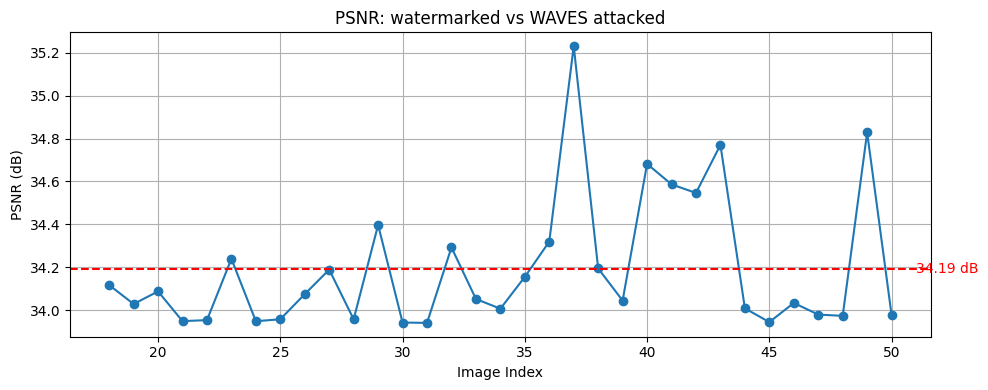

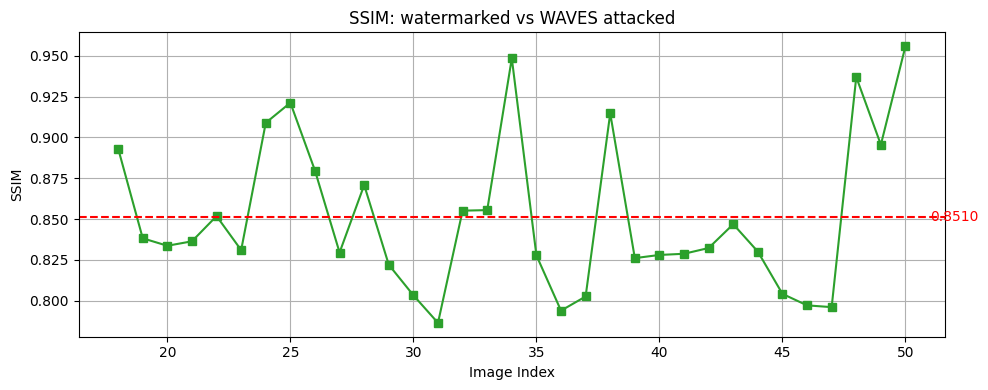

In [38]:
import os
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# 경로 설정
wm_dir = "/content/drive/MyDrive/ssl_watermarking/ssl_output/imgs"
attacked_dir = "/content/drive/MyDrive/ssl_watermarking/ssl_waves"

psnr_list = []
ssim_list = []
indices = []

# 50장 비교
for i in tqdm(range(1, 51)):
    fname = f"{i:02}.png"
    wm_path = os.path.join(wm_dir, fname)
    attacked_path = os.path.join(attacked_dir, f"attacked_{i:02}.png")

    if not os.path.exists(wm_path) or not os.path.exists(attacked_path):
        continue

    wm_img = Image.open(wm_path).convert("RGB")
    attacked_img = Image.open(attacked_path).convert("RGB").resize(wm_img.size)

    wm_np = np.array(wm_img).astype(np.uint8)
    attacked_np = np.array(attacked_img).astype(np.uint8)

    psnr_val = psnr(wm_np, attacked_np, data_range=255)
    ssim_val = ssim(wm_np, attacked_np, channel_axis=2)

    psnr_list.append(psnr_val)
    ssim_list.append(ssim_val)
    indices.append(i)

psnr_mean = np.mean(psnr_list)
ssim_mean = np.mean(ssim_list)

# PSNR/SSIM 시각화
plt.figure(figsize=(10, 4))
plt.plot(indices, psnr_list, marker='o', label="PSNR (dB)", color='tab:blue')
plt.axhline(y=psnr_mean, color='red', linestyle='--', label=f"avg: {psnr_mean:.2f} dB")  # ✅ 평균선
plt.text(indices[-1]+1, psnr_mean, f"{psnr_mean:.2f} dB", color='red', va='center')      # ✅ 텍스트
plt.xlabel("Image Index")
plt.ylabel("PSNR (dB)")
plt.title("PSNR: watermarked vs WAVES attacked")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(indices, ssim_list, marker='s', label="SSIM", color='tab:green')
plt.axhline(y=ssim_mean, color='red', linestyle='--', label=f"avg: {ssim_mean:.4f}")   # ✅ 평균선
plt.text(indices[-1]+1, ssim_mean, f"{ssim_mean:.4f}", color='red', va='center')
plt.xlabel("Image Index")
plt.ylabel("SSIM")
plt.title("SSIM: watermarked vs WAVES attacked")
plt.grid(True)
plt.tight_layout()
plt.show()

***

In [21]:
\# 1. 경로 설정
input_image_path = "/content/drive/MyDrive/watermarked_img/wm_01.png"
output_root_dir = "/content/drive/MyDrive/attack"
assert os.path.exists(output_root_dir), "attack 폴더가 존재하지 않습니다."

# 2. 공격 유형 정의
distortion_strength_paras = dict(
    rotation=(0, 45),
    resizedcrop=(1, 0.5),
    erasing=(0, 0.25),
    brightness=(1, 2),
    contrast=(1, 2),
    blurring=(0, 20),
    noise=(0, 0.1),
    compression=(90, 10),
)

# 3. 워터마크된 이미지 불러오기
base_img = Image.open(input_image_path).convert("RGB")

# 4. 공격 유형 반복
for distortion_type in distortion_strength_paras.keys():
    print(f"\n▶ 공격 유형: {distortion_type}")

    # 기존 폴더 확인
    output_dir = os.path.join(output_root_dir, distortion_type)
    os.makedirs(output_dir, exist_ok=True)

    # 강도 10단계 반복
    for i, rel_strength in enumerate(np.linspace(0, 1, 10)):
        attacked_img = distortions.apply_distortion(
            [base_img],
            distortion_type=distortion_type,
            strength=rel_strength,
            distortion_seed=i,
            same_operation=True,
            relative_strength=True,
            return_image=True
        )[0]

        save_path = os.path.join(output_dir, f"{distortion_type}_{i+1:02d}.png")
        attacked_img.save(save_path)
        print(f"  - [{i+1}/10] 저장 완료: {save_path}")



▶ 공격 유형: rotation
  - [1/10] 저장 완료: /content/drive/MyDrive/attack/rotation/rotation_01.png
  - [2/10] 저장 완료: /content/drive/MyDrive/attack/rotation/rotation_02.png
  - [3/10] 저장 완료: /content/drive/MyDrive/attack/rotation/rotation_03.png
  - [4/10] 저장 완료: /content/drive/MyDrive/attack/rotation/rotation_04.png
  - [5/10] 저장 완료: /content/drive/MyDrive/attack/rotation/rotation_05.png
  - [6/10] 저장 완료: /content/drive/MyDrive/attack/rotation/rotation_06.png
  - [7/10] 저장 완료: /content/drive/MyDrive/attack/rotation/rotation_07.png
  - [8/10] 저장 완료: /content/drive/MyDrive/attack/rotation/rotation_08.png
  - [9/10] 저장 완료: /content/drive/MyDrive/attack/rotation/rotation_09.png
  - [10/10] 저장 완료: /content/drive/MyDrive/attack/rotation/rotation_10.png

▶ 공격 유형: resizedcrop
  - [1/10] 저장 완료: /content/drive/MyDrive/attack/resizedcrop/resizedcrop_01.png
  - [2/10] 저장 완료: /content/drive/MyDrive/attack/resizedcrop/resizedcrop_02.png
  - [3/10] 저장 완료: /content/drive/MyDrive/attack/resizedcrop/resizedcro